In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import sys
import os
import tqdm
import gc
import copy

from collections import defaultdict
import itertools

import plotly as ply
ply.io.renderers.default="notebook"

import ipywidgets as widgets
from ipywidgets import interact

import sklearn as skl
from sklearn.neighbors import KernelDensity

In [2]:
dataDir='dataFiles'
ionData=pd.read_csv('/'.join([dataDir,'Ion_Coordinate_Data.csv']))
ionData.head()

,Potential,Frame,Ion_Index,Z
0,0.2,0,1357,-25.384398
1,0.2,1,1357,-34.099881
2,0.2,2,1357,-41.649691
3,0.2,3,1357,-40.350572
4,0.2,4,1357,-39.439099


In [4]:
ionData.groupby('Potential').describe().T

Potential                 -0.2            0.2
Frame     count  267813.000000  267813.000000
          mean     4959.000000    4959.000000
          std      2863.373991    2863.373991
          min         0.000000       0.000000
          25%      2479.000000    2479.000000
          50%      4959.000000    4959.000000
          75%      7439.000000    7439.000000
          max      9918.000000    9918.000000
Ion_Index count  267813.000000  267813.000000
          mean     1370.000000    1370.000000
          std         7.788896       7.788896
          min      1357.000000    1357.000000
          25%      1363.000000    1363.000000
          50%      1370.000000    1370.000000
          75%      1377.000000    1377.000000
          max      1383.000000    1383.000000
Z         count  267813.000000  267813.000000
          mean      -16.372790     -13.860706
          std        29.927054      32.406261
          min       -84.336787     -84.834234
          25%       -28.726879     -28.993487
          50%       -23.046127     -22.793476
          75%       -16.131300     -15.217315
          max        83.019765      82.769893

In [5]:
zmin=-30
zmax=30

ionData['Zi_30']=ionData.Z.transform(
    lambda z: np.clip(z,zmin,zmax))

ionData.head()

,Potential,Frame,Ion_Index,Z,Zi_30
0,0.2,0,1357,-25.384398,-25.384398
1,0.2,1,1357,-34.099881,-30.000000
2,0.2,2,1357,-41.649691,-30.000000
3,0.2,3,1357,-40.350572,-30.000000
4,0.2,4,1357,-39.439099,-30.000000


In [12]:
zmin=-30
zmax=30

ionData['Zi_30']=ionData.Z.transform(
    lambda z: np.clip(z,zmin,zmax))

display(ionData.head())

fluxSets=[]

for fluxGroup in tqdm.tqdm_notebook(ionData.groupby(['Potential','Ion_Index'])):
    fluxGroupName,fluxGroupData=fluxGroup
    fluxFrames=fluxGroupData.Frame.to_numpy()[:-1]
    zt0=fluxGroupData.Zi_30.to_numpy()[1:]
    zt1=fluxGroupData.Zi_30.to_numpy()[:-1]
    fluxVals=(zt0-zt1)*( ((zt0<zmax)*(zt0>zmin) + (zt1<zmax)*(zt1>zmin)) > 0 )
    fluxSets.append(pd.DataFrame({
        'Potential':[fluxGroupName[0]]*len(fluxVals),
        'Frame':fluxFrames,
        'Ion_Index':[fluxGroupName[1]]*len(fluxVals),
        'Flux':fluxVals
    }))

fluxData=pd.concat(fluxSets)
fluxData.head()

,Potential,Frame,Ion_Index,Z,Zi_30
0,0.2,0,1357,-25.384398,-25.384398
1,0.2,1,1357,-34.099881,-30.000000
2,0.2,2,1357,-41.649691,-30.000000
3,0.2,3,1357,-40.350572,-30.000000
4,0.2,4,1357,-39.439099,-30.000000


,Potential,Frame,Ion_Index,Flux
0,-0.2,0,1357,-4.615602
1,-0.2,1,1357,0.000000
2,-0.2,2,1357,0.000000
3,-0.2,3,1357,0.000000
4,-0.2,4,1357,0.547319


In [14]:
netFluxData=fluxData[['Potential','Frame','Flux']].groupby(['Potential','Frame']).agg('mean')
netFluxData=netFluxData.reset_index()
netFluxData.head()

,Potential,Frame,Flux
0,-0.2,0,-8.176743
1,-0.2,1,0.275306
2,-0.2,2,-0.416505
3,-0.2,3,0.019912
4,-0.2,4,0.146489


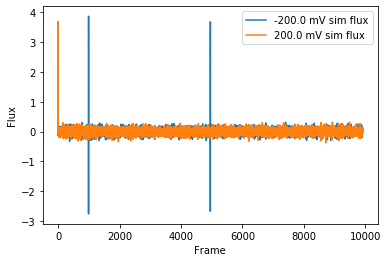

In [26]:
netFluxData=fluxData[['Potential','Frame','Flux']].groupby(['Potential','Frame']).agg('sum')
netFluxData=netFluxData.reset_index()
netFluxData.head()
for potGroup in netFluxData.groupby('Potential'):
    potGroupName,potGroupData=potGroup
    sns.lineplot(potGroupData.Frame,-potGroupData.Flux/(zmax-zmin),
                 label='%.1f mV sim flux'%(1000*float(potGroupName)))

plt.show()

In [31]:
(
    fluxData[['Potential','Frame','Flux']].groupby(['Potential','Frame']).agg('sum').reset_index()
)[['Potential','Flux']].groupby('Potential').agg('sum')

,Flux
Potential,
-0.2,449.684287
0.2,-781.616801


In [30]:
fluxData[['Potential','Frame','Flux']].groupby(['Potential','Frame']).agg('sum').reset_index()

,Potential,Frame,Flux
0,-0.2,0,-220.772072
1,-0.2,1,7.433257
2,-0.2,2,-11.245632
3,-0.2,3,0.537630
4,-0.2,4,3.955203
5,-0.2,5,-1.668714
6,-0.2,6,0.229817
7,-0.2,7,-1.301875
8,-0.2,8,7.071347
9,-0.2,9,-0.624149
